In [1]:
import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import sklearn, sklearn.linear_model

import loader
from models import BinningCalibrator
import utils

split_ratio_test = 0.3
split_ratio_postproc = 0.5  # among all training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 38)

# This seed controls the randomness during pre-training (fixed)
seed_pretrain = 33

# Settings for calibration
n_bins_calib = 10
split_ratio_calib = 0.8

max_workers = 32

data_dir = "data/compas"

In [2]:
## Load ProPublica COMPAS dataset

(inputs_df, labels, label_names, groups,
 group_names) = loader.load_compas(data_dir)
inputs_u_df = loader.load_compas(data_dir, remove_sensitive_attr=True)[0]
      
display(loader.dataset_stats(labels, label_names, groups, group_names))

n_classes = len(label_names)
n_groups = len(group_names)

inputs = np.array(inputs_df.values, dtype=np.float32)
inputs_u = np.array(inputs_u_df.values, dtype=np.float32)

Group,African-American,Caucasian
Target,,
No,1402,1229
Yes,1773,874


In [3]:
## Split data into (test + post-processing) and pre-training sets

(inputs_, inputs_pretrain, inputs_u_, inputs_u_pretrain, labels_,
 labels_pretrain, groups_,
 groups_pretrain) = sklearn.model_selection.train_test_split(
     inputs,
     inputs_u,
     labels,
     groups,
     test_size=(1 - split_ratio_test) * (1 - split_ratio_postproc),
     random_state=seed_pretrain,
 )

# Encode the joint (A, Y) labels by flattening
labels_ay_pretrain = groups_pretrain * n_classes + labels_pretrain

# Normalize data
scaler = sklearn.preprocessing.StandardScaler()
inputs_pretrain = scaler.fit_transform(inputs_pretrain)
inputs_ = scaler.transform(inputs_)

scaler = sklearn.preprocessing.StandardScaler()
inputs_u_pretrain = scaler.fit_transform(inputs_u_pretrain)
inputs_u_ = scaler.transform(inputs_u_)

n_samples = len(inputs)
n_test = int(n_samples * split_ratio_test)

## Logistic regression

In [4]:
# Train attribute-aware p(Y | X) predictor
predictor_y = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Calibration error of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

Calibration error of attribute-blind predictor: 0.15885262651452192


In [5]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

Code for post-processing a single model (with precomputed probas):

    postprocessor = postprocess.PostProcessor(
        n_classes,
        n_groups,
        pred_ay_fn=lambda x: x,  # dummy pred_fn
        criterion='sp',
        alpha=alpha,
        seed=seed,
    )
    postprocessor.fit(probas_ay_postproc)
    preds = postprocessor.predict(probas_ay_test)


  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

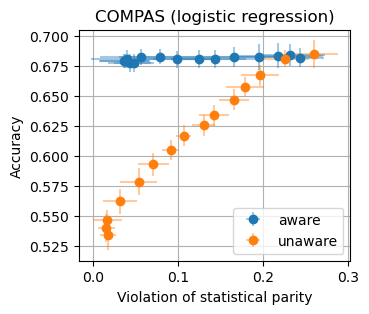

Results for attribute-aware setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.681996  0.007719  0.243296  0.028292
0.240  0.684018  0.009427  0.232082  0.040717
0.220  0.683512  0.010542  0.217679  0.053186
0.200  0.682881  0.010841  0.194874  0.064948
0.180  0.682754  0.008397  0.165456  0.060369
0.160  0.680733  0.007719  0.143957  0.052160
0.140  0.680733  0.007588  0.125169  0.054170
0.120  0.680733  0.007043  0.098253  0.050534
0.100  0.682502  0.006247  0.078299  0.048257
0.080  0.682502  0.006544  0.056251  0.048536
0.060  0.680985  0.007407  0.040181  0.041927
0.040  0.679217  0.006033  0.037413  0.030154
0.020  0.679217  0.005882  0.036892  0.028909
0.010  0.677574  0.007321  0.043249  0.025177
0.001  0.677322  0.007559  0.048114  0.023344

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.684902  0.011574  0.259447  0.028586
0.240  0.681112  0.007167  0.225851  0.027809
0.220  0.667088  0.009023  0.196656  0.022283
0.200  0.657107  0.008373  0.178759  0.022066
0.180  0.646873  0.008967  0.165271  0.017639
0.160  0.633986  0.008783  0.142257  0.017807
0.140  0.625648  0.008669  0.129922  0.013839
0.120  0.616930  0.008985  0.106576  0.008994
0.100  0.605180  0.008321  0.091389  0.009735
0.080  0.593051  0.009636  0.070943  0.017857
0.060  0.578395  0.011253  0.053831  0.021617
0.040  0.562097  0.010696  0.031814  0.019950
0.020  0.546304  0.008620  0.016866  0.017309
0.010  0.539987  0.011703  0.015735  0.009781
0.001  0.534176  0.012796  0.018174  0.009428

In [6]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
        0.02, 0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    print_code=True,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
        0.02, 0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_sp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("COMPAS (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

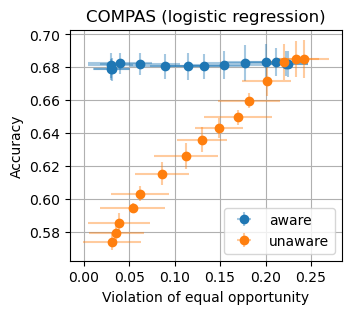

Results for attribute-aware setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.681996  0.007719   0.224155  0.023046
0.220  0.682249  0.007698   0.222622  0.024250
0.200  0.683260  0.008599   0.211338  0.035527
0.180  0.683386  0.010696   0.200155  0.044023
0.160  0.682628  0.010689   0.177335  0.045809
0.140  0.681491  0.008701   0.154631  0.043338
0.120  0.680606  0.007416   0.132201  0.045098
0.100  0.680606  0.008110   0.114418  0.041740
0.080  0.680606  0.007496   0.089466  0.038665
0.060  0.681870  0.006709   0.062091  0.043829
0.040  0.682502  0.006405   0.039885  0.035390
0.020  0.681238  0.007429   0.029788  0.024712
0.010  0.678838  0.006900   0.031116  0.019329
0.001  0.678838  0.006263   0.030246  0.019856

Results for attribute-blind setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.684902  0.011574   0.242624  0.027334
0.240  0.684902  0.010927   0.233772  0.025045
0.220  0.683260  0.010983   0.220491  0.022160
0.200  0.671762  0.009150   0.201237  0.026879
0.180  0.659760  0.004612   0.181849  0.033658
0.160  0.649653  0.004568   0.169278  0.037312
0.140  0.643083  0.006333   0.148547  0.026632
0.120  0.636008  0.007440   0.130243  0.027752
0.100  0.626279  0.007860   0.112581  0.034914
0.080  0.615414  0.006766   0.086023  0.029941
0.060  0.603159  0.004542   0.061966  0.032337
0.040  0.594441  0.002860   0.054094  0.035865
0.020  0.585471  0.005745   0.038916  0.033795
0.010  0.579533  0.004966   0.036093  0.030085
0.001  0.574100  0.005255   0.030805  0.031952

In [7]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
        0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eopp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("COMPAS (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

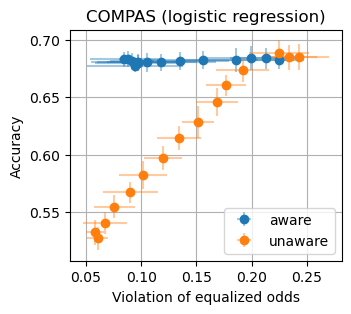

Results for attribute-aware setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.681996  0.007719  0.224155  0.023046
0.220  0.684018  0.009104  0.212925  0.032885
0.200  0.684144  0.010157  0.199035  0.043838
0.180  0.682502  0.010270  0.185741  0.052280
0.160  0.682375  0.007755  0.155684  0.049797
0.140  0.681491  0.008205  0.135025  0.044034
0.120  0.680354  0.007147  0.118171  0.049355
0.100  0.680985  0.006396  0.097155  0.042821
0.080  0.683007  0.006736  0.084617  0.030625
0.060  0.683007  0.006766  0.088506  0.008740
0.040  0.681364  0.006813  0.091485  0.019952
0.020  0.679975  0.007015  0.096856  0.038409
0.010  0.680354  0.008357  0.105115  0.044703
0.001  0.677322  0.005532  0.094583  0.043154

Results for attribute-blind setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.684902  0.011574  0.242624  0.027334
0.240  0.684902  0.010927  0.233772  0.025045
0.220  0.688692  0.010881  0.224541  0.026927
0.200  0.673405  0.010245  0.191734  0.023871
0.180  0.660265  0.008949  0.176674  0.017914
0.160  0.645989  0.012181  0.168662  0.018953
0.140  0.628174  0.013816  0.151621  0.014344
0.120  0.614782  0.010584  0.134123  0.020009
0.100  0.597473  0.010489  0.119658  0.017238
0.080  0.582059  0.012107  0.101419  0.021629
0.060  0.567277  0.009154  0.090285  0.024687
0.040  0.554896  0.010250  0.075765  0.018609
0.020  0.540745  0.009837  0.066973  0.019854
0.010  0.532407  0.011189  0.058082  0.008196
0.001  0.527227  0.010309  0.060884  0.009556

In [8]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
        0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eo', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("COMPAS (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

## Gradient boosting decision tree

In [9]:
# Train attribute-aware p(Y | X) predictor
predictor_y = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Calibration error of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

[LightGBM] [Info] Number of positive: 938, number of negative: 910
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 1848, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.507576 -> initscore=0.030305
[LightGBM] [Info] Start training from score 0.030305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 184
[LightGBM] [Info] Number of data points in the train set: 1848, number of used features: 7
[LightGBM] [Info] Start training from score -1.350159
[LightGBM] [Info] Start training from score -1.116631
[LightGBM] [Info] Start training from score -1.455751
[LightGBM] [Info] Start training from score -1.713717


Calibration error of attribute-blind predictor: 0.5550889406798768


In [10]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

Code for post-processing a single model (with precomputed probas):

    postprocessor = postprocess.PostProcessor(
        n_classes,
        n_groups,
        pred_ay_fn=lambda x: x,  # dummy pred_fn
        criterion='sp',
        alpha=alpha,
        seed=seed,
    )
    postprocessor.fit(probas_ay_postproc)
    preds = postprocessor.predict(probas_ay_test)


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

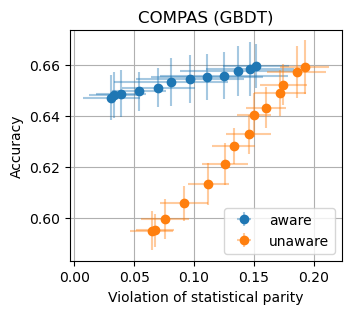

Results for attribute-aware setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.659634  0.008468  0.151550  0.027754
0.180  0.658497  0.010614  0.146973  0.036791
0.160  0.657738  0.009882  0.136442  0.048312
0.140  0.655843  0.009191  0.124692  0.053437
0.120  0.655464  0.009029  0.110850  0.046841
0.100  0.654454  0.009370  0.096418  0.045358
0.080  0.653190  0.009423  0.080770  0.047636
0.060  0.651169  0.007612  0.070200  0.030154
0.040  0.649653  0.007770  0.054357  0.022535
0.020  0.648768  0.009359  0.038892  0.020830
0.010  0.648389  0.009051  0.033509  0.021630
0.001  0.647126  0.008806  0.030998  0.024130

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.659255  0.010500  0.192264  0.020597
0.210  0.657359  0.010202  0.185813  0.024582
0.200  0.652306  0.007998  0.174644  0.019589
0.180  0.648895  0.009049  0.171581  0.021612
0.160  0.643209  0.008058  0.159820  0.016678
0.140  0.640430  0.008655  0.149967  0.013860
0.120  0.632849  0.007703  0.145472  0.018834
0.100  0.628048  0.007040  0.133090  0.017865
0.080  0.620973  0.008273  0.125806  0.019348
0.060  0.613266  0.008326  0.111990  0.017179
0.040  0.605685  0.006969  0.091750  0.019856
0.020  0.599495  0.007698  0.075686  0.020039
0.010  0.595073  0.006580  0.067293  0.015594
0.001  0.594946  0.007703  0.064565  0.017778

In [11]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    print_code=True,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.21, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
        0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_sp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("COMPAS (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

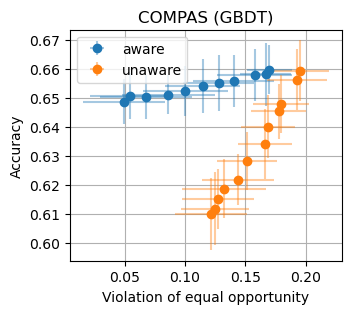

Results for attribute-aware setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.659634  0.008468   0.169876  0.018247
0.160  0.657991  0.010726   0.166756  0.021288
0.140  0.657865  0.008873   0.157582  0.031057
0.120  0.655717  0.009045   0.140090  0.033921
0.100  0.655085  0.009570   0.127853  0.029208
0.080  0.654075  0.009312   0.114423  0.030857
0.060  0.652179  0.008576   0.100229  0.035177
0.040  0.651042  0.006664   0.086149  0.038720
0.020  0.650284  0.007483   0.067479  0.037850
0.010  0.650537  0.007895   0.054008  0.033053
0.001  0.648642  0.007690   0.049092  0.034003

Results for attribute-blind setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.659255  0.010500   0.194866  0.024466
0.180  0.656222  0.010432   0.192946  0.024923
0.160  0.647757  0.010014   0.179333  0.023504
0.140  0.645357  0.009408   0.177559  0.022973
0.120  0.640051  0.010918   0.168827  0.022522
0.100  0.633986  0.011991   0.166316  0.022367
0.080  0.628301  0.010014   0.151042  0.025011
0.060  0.621731  0.008758   0.143429  0.029860
0.040  0.618699  0.010054   0.132175  0.034558
0.020  0.615161  0.010200   0.127061  0.029653
0.010  0.611876  0.012416   0.124920  0.028206
0.001  0.609981  0.012432   0.121799  0.029827

In [12]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eopp', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("COMPAS (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

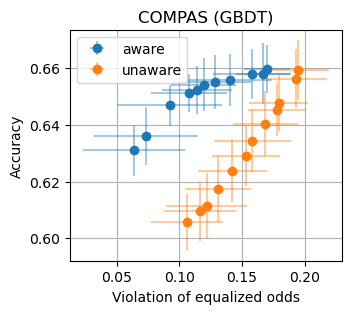

Results for attribute-aware setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.659634  0.008468  0.169876  0.018247
0.160  0.657991  0.010726  0.166756  0.021288
0.140  0.657865  0.008873  0.157582  0.031057
0.120  0.655717  0.009045  0.140090  0.033921
0.100  0.655085  0.009570  0.128031  0.028893
0.080  0.654075  0.009312  0.119348  0.025626
0.060  0.652179  0.008576  0.114204  0.027740
0.040  0.651042  0.006664  0.108026  0.030193
0.020  0.646873  0.007189  0.092331  0.041676
0.010  0.636134  0.010274  0.073541  0.041613
0.001  0.630954  0.008961  0.063651  0.040662

Results for attribute-blind setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.659255  0.010500  0.194866  0.024466
0.180  0.656222  0.010432  0.192946  0.024923
0.160  0.647757  0.010014  0.179333  0.023504
0.140  0.645357  0.009408  0.177559  0.022973
0.120  0.640303  0.011472  0.168534  0.025897
0.100  0.634365  0.011189  0.158028  0.030629
0.080  0.628932  0.010623  0.153209  0.027323
0.060  0.623752  0.011047  0.142106  0.027633
0.040  0.617435  0.011619  0.130721  0.026573
0.020  0.611497  0.011380  0.121685  0.032205
0.010  0.609476  0.010316  0.116456  0.028739
0.001  0.605685  0.009882  0.106290  0.028464

In [13]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_aware, 'delta_eo', 'accuracy', label='aware')
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("COMPAS (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-blind setting:")
display(df_blind)

## Calibration (attribute-blind setting)

In [14]:
# Split pre-training data into calibration and training sets
inputs_u_train, inputs_u_calib, labels_ay_train, labels_ay_calib = sklearn.model_selection.train_test_split(
    inputs_u_pretrain,
    labels_ay_pretrain,
    test_size=split_ratio_calib,
    random_state=seed_pretrain,
)

### Logistic regression

In [15]:
# Train p(A, Y | X) predictor
predictor_u_ay = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_train, labels_ay_train)

# Train p(A, Y | X) calibrator
calib = BinningCalibrator(n_bins_calib, random_state=seed_pretrain)
calib.fit(predictor_u_ay.predict_proba(inputs_u_calib), labels_ay_calib);

In [16]:
# Precompute and calibrate P(A, Y | X) on (test + post-processing) set
probas_ay_u_ = calib.predict_proba(
    predictor_u_ay.predict_proba(inputs_u_)).reshape(-1, n_groups, n_classes)

postprocess_u_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_u_,
    'max_workers': max_workers,
}

  0%|          | 0/75 [00:00<?, ?it/s]

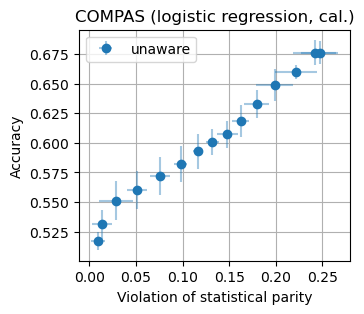

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.676437  0.009395  0.247141  0.019721
0.240  0.676437  0.010394  0.241636  0.023324
0.220  0.660139  0.006010  0.221619  0.022376
0.200  0.649021  0.013516  0.198806  0.019996
0.180  0.632975  0.012151  0.179512  0.013256
0.160  0.618699  0.013300  0.162270  0.009296
0.140  0.607328  0.011217  0.148001  0.011176
0.120  0.600884  0.011135  0.131825  0.007180
0.100  0.593051  0.014811  0.116422  0.005424
0.080  0.582059  0.015033  0.097810  0.006654
0.060  0.572205  0.015971  0.075390  0.010729
0.040  0.560076  0.016109  0.050741  0.010782
0.020  0.551105  0.016331  0.028367  0.018300
0.010  0.531143  0.012269  0.013787  0.010948
0.001  0.516867  0.007599  0.009445  0.007266

In [17]:
## Post-processing for statistical parity

df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
        0.02, 0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("COMPAS (logistic regression, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/75 [00:00<?, ?it/s]

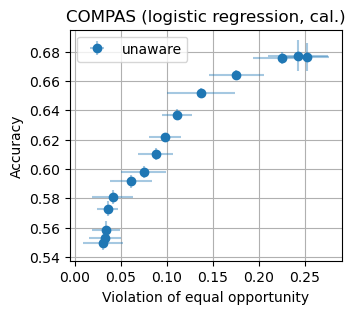

Results for attribute-blind setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.676437  0.009395   0.252118  0.024630
0.240  0.677322  0.010499   0.243065  0.032546
0.220  0.675553  0.004084   0.225201  0.031443
0.200  0.664182  0.003448   0.175960  0.029453
0.180  0.651674  0.003448   0.137482  0.037344
0.160  0.637018  0.003806   0.111383  0.015898
0.140  0.621984  0.002170   0.098124  0.017130
0.120  0.610107  0.003980   0.088133  0.018880
0.100  0.597979  0.003935   0.075122  0.024243
0.080  0.591535  0.004547   0.061189  0.022643
0.060  0.580796  0.004698   0.041350  0.021978
0.040  0.572963  0.005379   0.035921  0.011343
0.020  0.558307  0.005814   0.034230  0.015397
0.010  0.552748  0.004166   0.032995  0.016950
0.001  0.549337  0.004844   0.030615  0.021919

In [18]:
## Post-processing for equal opportunity

df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("COMPAS (logistic regression, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/75 [00:00<?, ?it/s]

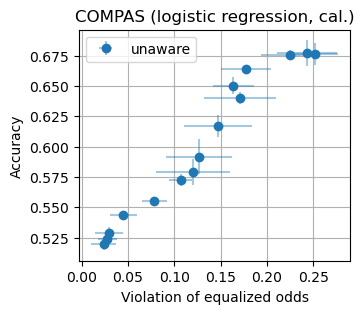

Results for attribute-blind setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.676437  0.009395  0.252118  0.024630
0.240  0.677322  0.010499  0.243065  0.032546
0.220  0.675553  0.004084  0.225201  0.031443
0.200  0.664182  0.003448  0.177593  0.026632
0.180  0.650284  0.007113  0.163878  0.022209
0.160  0.640303  0.004719  0.170811  0.039151
0.140  0.617183  0.009133  0.147236  0.036916
0.120  0.591788  0.014621  0.127208  0.035645
0.100  0.579027  0.010633  0.120504  0.039833
0.080  0.572331  0.004954  0.107050  0.012593
0.060  0.555022  0.003331  0.078261  0.013423
0.040  0.543272  0.002825  0.045118  0.014661
0.020  0.528743  0.004621  0.029416  0.015399
0.010  0.523689  0.004331  0.028005  0.010647
0.001  0.520025  0.005442  0.024005  0.013264

In [19]:
## Post-processing for equalized odds

df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("COMPAS (logistic regression, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

### Gradient boosting decision tree

In [20]:
# Train p(A, Y | X) predictor
predictor_u_ay = lightgbm.LGBMClassifier(random_state=seed_pretrain,
                                         verbosity=-1)
predictor_u_ay.fit(inputs_u_train, labels_ay_train)

# Train p(A, Y | X) calibrator
calib = BinningCalibrator(n_bins_calib, random_state=seed_pretrain)
calib.fit(predictor_u_ay.predict_proba(inputs_u_calib), labels_ay_calib);

In [21]:
# Precompute and calibrate P(A, Y | X) on (test + post-processing) set
probas_ay_u_ = calib.predict_proba(
    predictor_u_ay.predict_proba(inputs_u_)).reshape(-1, n_groups, n_classes)

postprocess_u_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_u_,
    'max_workers': max_workers,
}

  0%|          | 0/55 [00:00<?, ?it/s]

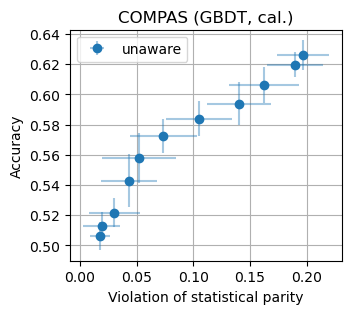

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.626027  0.009908  0.196782  0.022874
0.160  0.619709  0.008321  0.189386  0.024427
0.140  0.606317  0.011745  0.162300  0.030683
0.120  0.593936  0.014359  0.140143  0.028422
0.100  0.583955  0.011798  0.104908  0.028775
0.080  0.572331  0.011371  0.073623  0.029522
0.060  0.557802  0.016690  0.051991  0.032861
0.040  0.542767  0.017583  0.043075  0.024823
0.020  0.521668  0.009553  0.030466  0.022764
0.010  0.512824  0.009490  0.019152  0.016682
0.001  0.506254  0.009450  0.018012  0.008874

In [22]:
## Post-processing for statistical parity

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_sp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("COMPAS (GBDT, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/45 [00:00<?, ?it/s]

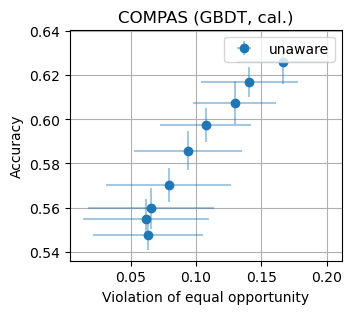

Results for attribute-blind setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.626027  0.009908   0.166498  0.035402
0.120  0.617183  0.006818   0.140906  0.037130
0.100  0.607581  0.009831   0.129616  0.031542
0.080  0.597347  0.007809   0.107547  0.034836
0.060  0.585850  0.008851   0.093970  0.041009
0.040  0.570310  0.007638   0.079024  0.047645
0.020  0.559570  0.009490   0.065581  0.048410
0.010  0.554769  0.009159   0.061563  0.048296
0.001  0.547442  0.006813   0.063113  0.041873

In [23]:
## Post-processing for equal opportunity

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eopp', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("COMPAS (GBDT, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)

  0%|          | 0/50 [00:00<?, ?it/s]

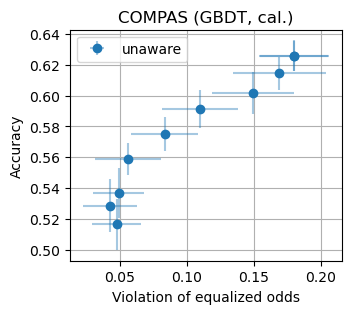

Results for attribute-blind setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.626027  0.009908  0.180153  0.025910
0.140  0.625900  0.009791  0.179599  0.025679
0.120  0.614529  0.010668  0.169014  0.034866
0.100  0.601769  0.013859  0.149238  0.030610
0.080  0.591535  0.012311  0.110070  0.028185
0.060  0.575237  0.011190  0.083400  0.025080
0.040  0.558939  0.010640  0.055975  0.024519
0.020  0.536829  0.016250  0.049201  0.019194
0.010  0.528743  0.017027  0.042563  0.020188
0.001  0.516488  0.016717  0.047763  0.018291

In [24]:
## Post-processing for equalized odds

df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax, df_blind, 'delta_eo', 'accuracy', label='unaware')
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("COMPAS (GBDT, cal.)")
ax.legend()
plt.show()

print("Results for attribute-blind setting:")
display(df_blind)